1. Создайте модель линейной регрессии, которая бы оценивала лояльность пользователей к отклику.

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import io
from pathlib import Path

In [203]:
dataset_filename = './ClientsData.csv'
df = pd.read_csv(dataset_filename)

In [4]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
info_filename = f'./{Path(dataset_filename).stem}_info.xlsx'
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
df_info = pd.merge(
    pd.DataFrame(lines, columns=columns[1:])
    , df.nunique().to_frame(name='Nu'), 
    left_on='Column', 
    right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
df_info = df_info[['Column', 'Non-Null']].copy()\
    .join(pd.DataFrame(df.isna().sum()).rename(columns={0: 'Null_cnt'}), how='left', on='Column')\
    .join(pd.DataFrame(df.isna().sum() / df.shape[0]).round(3).rename(columns={0: 'Null_percent'}), how='left', on='Column')\
    .join(df_info.set_index('Column').drop(columns=['Non-Null', 'Count'] ), how='left', on='Column')
if not Path(info_filename).exists():
    df_info.to_excel(info_filename, index=False)
df_info

,Column,Non-Null,Null_cnt,Null_percent,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,AGE,15223,0,0.0,int64,47,NaN,15223.0,40.406096,11.601068,21.0,30.0,39.0,50.0,67.0
1,SOCSTATUS_WORK_FL,15223,0,0.0,int64,2,"[(0, 1376), (1, 13847)]",15223.0,0.909610,0.286748,0.0,1.0,1.0,1.0,1.0
2,SOCSTATUS_PENS_FL,15223,0,0.0,int64,2,"[(0, 13176), (1, 2047)]",15223.0,0.134468,0.341165,0.0,0.0,0.0,0.0,1.0
3,GENDER,15223,0,0.0,int64,2,"[(0, 5259), (1, 9964)]",15223.0,0.654536,0.475535,0.0,0.0,1.0,1.0,1.0
4,CHILD_TOTAL,15223,0,0.0,int64,10,"[(0, 4984), (1, 5087), (2, 4140), (3, 799), (4...",15223.0,1.099389,0.995411,0.0,0.0,1.0,2.0,10.0
5,DEPENDANTS,15223,0,0.0,int64,8,"[(0, 8226), (1, 4535), (2, 2167), (3, 243), (4...",15223.0,0.645208,0.812252,0.0,0.0,0.0,1.0,7.0
6,PERSONAL_INCOME,15223,0,0.0,float64,274,NaN,15223.0,13853.836323,9015.467617,24.0,8000.0,12000.0,17000.0,250000.0
7,LOAN_NUM_TOTAL,15223,0,0.0,int64,9,"[(1, 11288), (2, 2633), (3, 871), (4, 275), (5...",15223.0,1.387769,0.793566,1.0,1.0,1.0,2.0,11.0
8,LOAN_NUM_CLOSED,15223,0,0.0,int64,10,"[(0, 7791), (1, 4761), (2, 1770), (3, 603), (4...",15223.0,0.751889,0.988499,0.0,0.0,0.0,1.0,11.0
9,LOAN_DLQ_NUM,15223,0,0.0,int64,14,"[(0, 13301), (1, 1416), (2, 280), (3, 96), (4,...",15223.0,0.195362,0.685022,0.0,0.0,0.0,0.0,13.0


In [5]:
# • TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);
# • AGE — возраст клиента;
# • SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);
# • SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
# • GENDER — пол клиента (1 — мужчина, 0 — женщина);
# • CHILD_TOTAL — количество детей клиента;
# • DEPENDANTS — количество иждивенцев клиента;
# • PERSONAL_INCOME — личный доход клиента (в рублях);
# • LOAN_NUM_TOTAL — количество ссуд клиента;
# • LOAN_NUM_CLOSED — количество погашенных ссуд клиента.

In [107]:
target_feature_name = 'TARGET'

In [6]:
# 18.5% дубликатов в датасете
df.duplicated().value_counts()/df.shape[0]

False    0.81482
True     0.18518
Name: count, dtype: float64

In [7]:
# Соотношение меток классов целевой переменной
df[target_feature_name].value_counts()/df.shape[0]

TARGET
0    0.88097
1    0.11903
Name: count, dtype: float64

In [8]:
# Соотношение меток классов целевой переменной в дубликатах
df.loc[df.duplicated(), [target_feature_name]].value_counts()

TARGET
0         2716
1          103
Name: count, dtype: int64

In [9]:
# Датасет не имеет пропусков
# Значения переменных не содержат нереальных значений (минимальные и максимальные значения не выходят за границы допустимых для домена)
# Объясняющие переменные за исключением PERSONAL_INCOME относятся к категории ранговых (имеют естественную порядковую связь) 
# либо бинарных и уже преобразованы в числовой формат.
# Дополнительного преобразования датасета не требуется.
# Датасет содержит дубликаты.
# Согласно мнению  изложенному здесь https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
# Все же дубликаты лучше удалить.
# Целевая переменная имеет два класса и распределение по классам не сбалансированное класс с меткой 1 составляет 12% от общего объема датасета. 
# Это нужно учесть при формировании тренировочного и тестового датасетов.
# Удаление дубликатов улучшить ситацуацию с несбалансированностью классов в целевой переменной, но незначительно.

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df[target_feature_name].value_counts()/df.shape[0]

TARGET
0    0.862222
1    0.137778
Name: count, dtype: float64

In [12]:
# Визуализируем признаки.

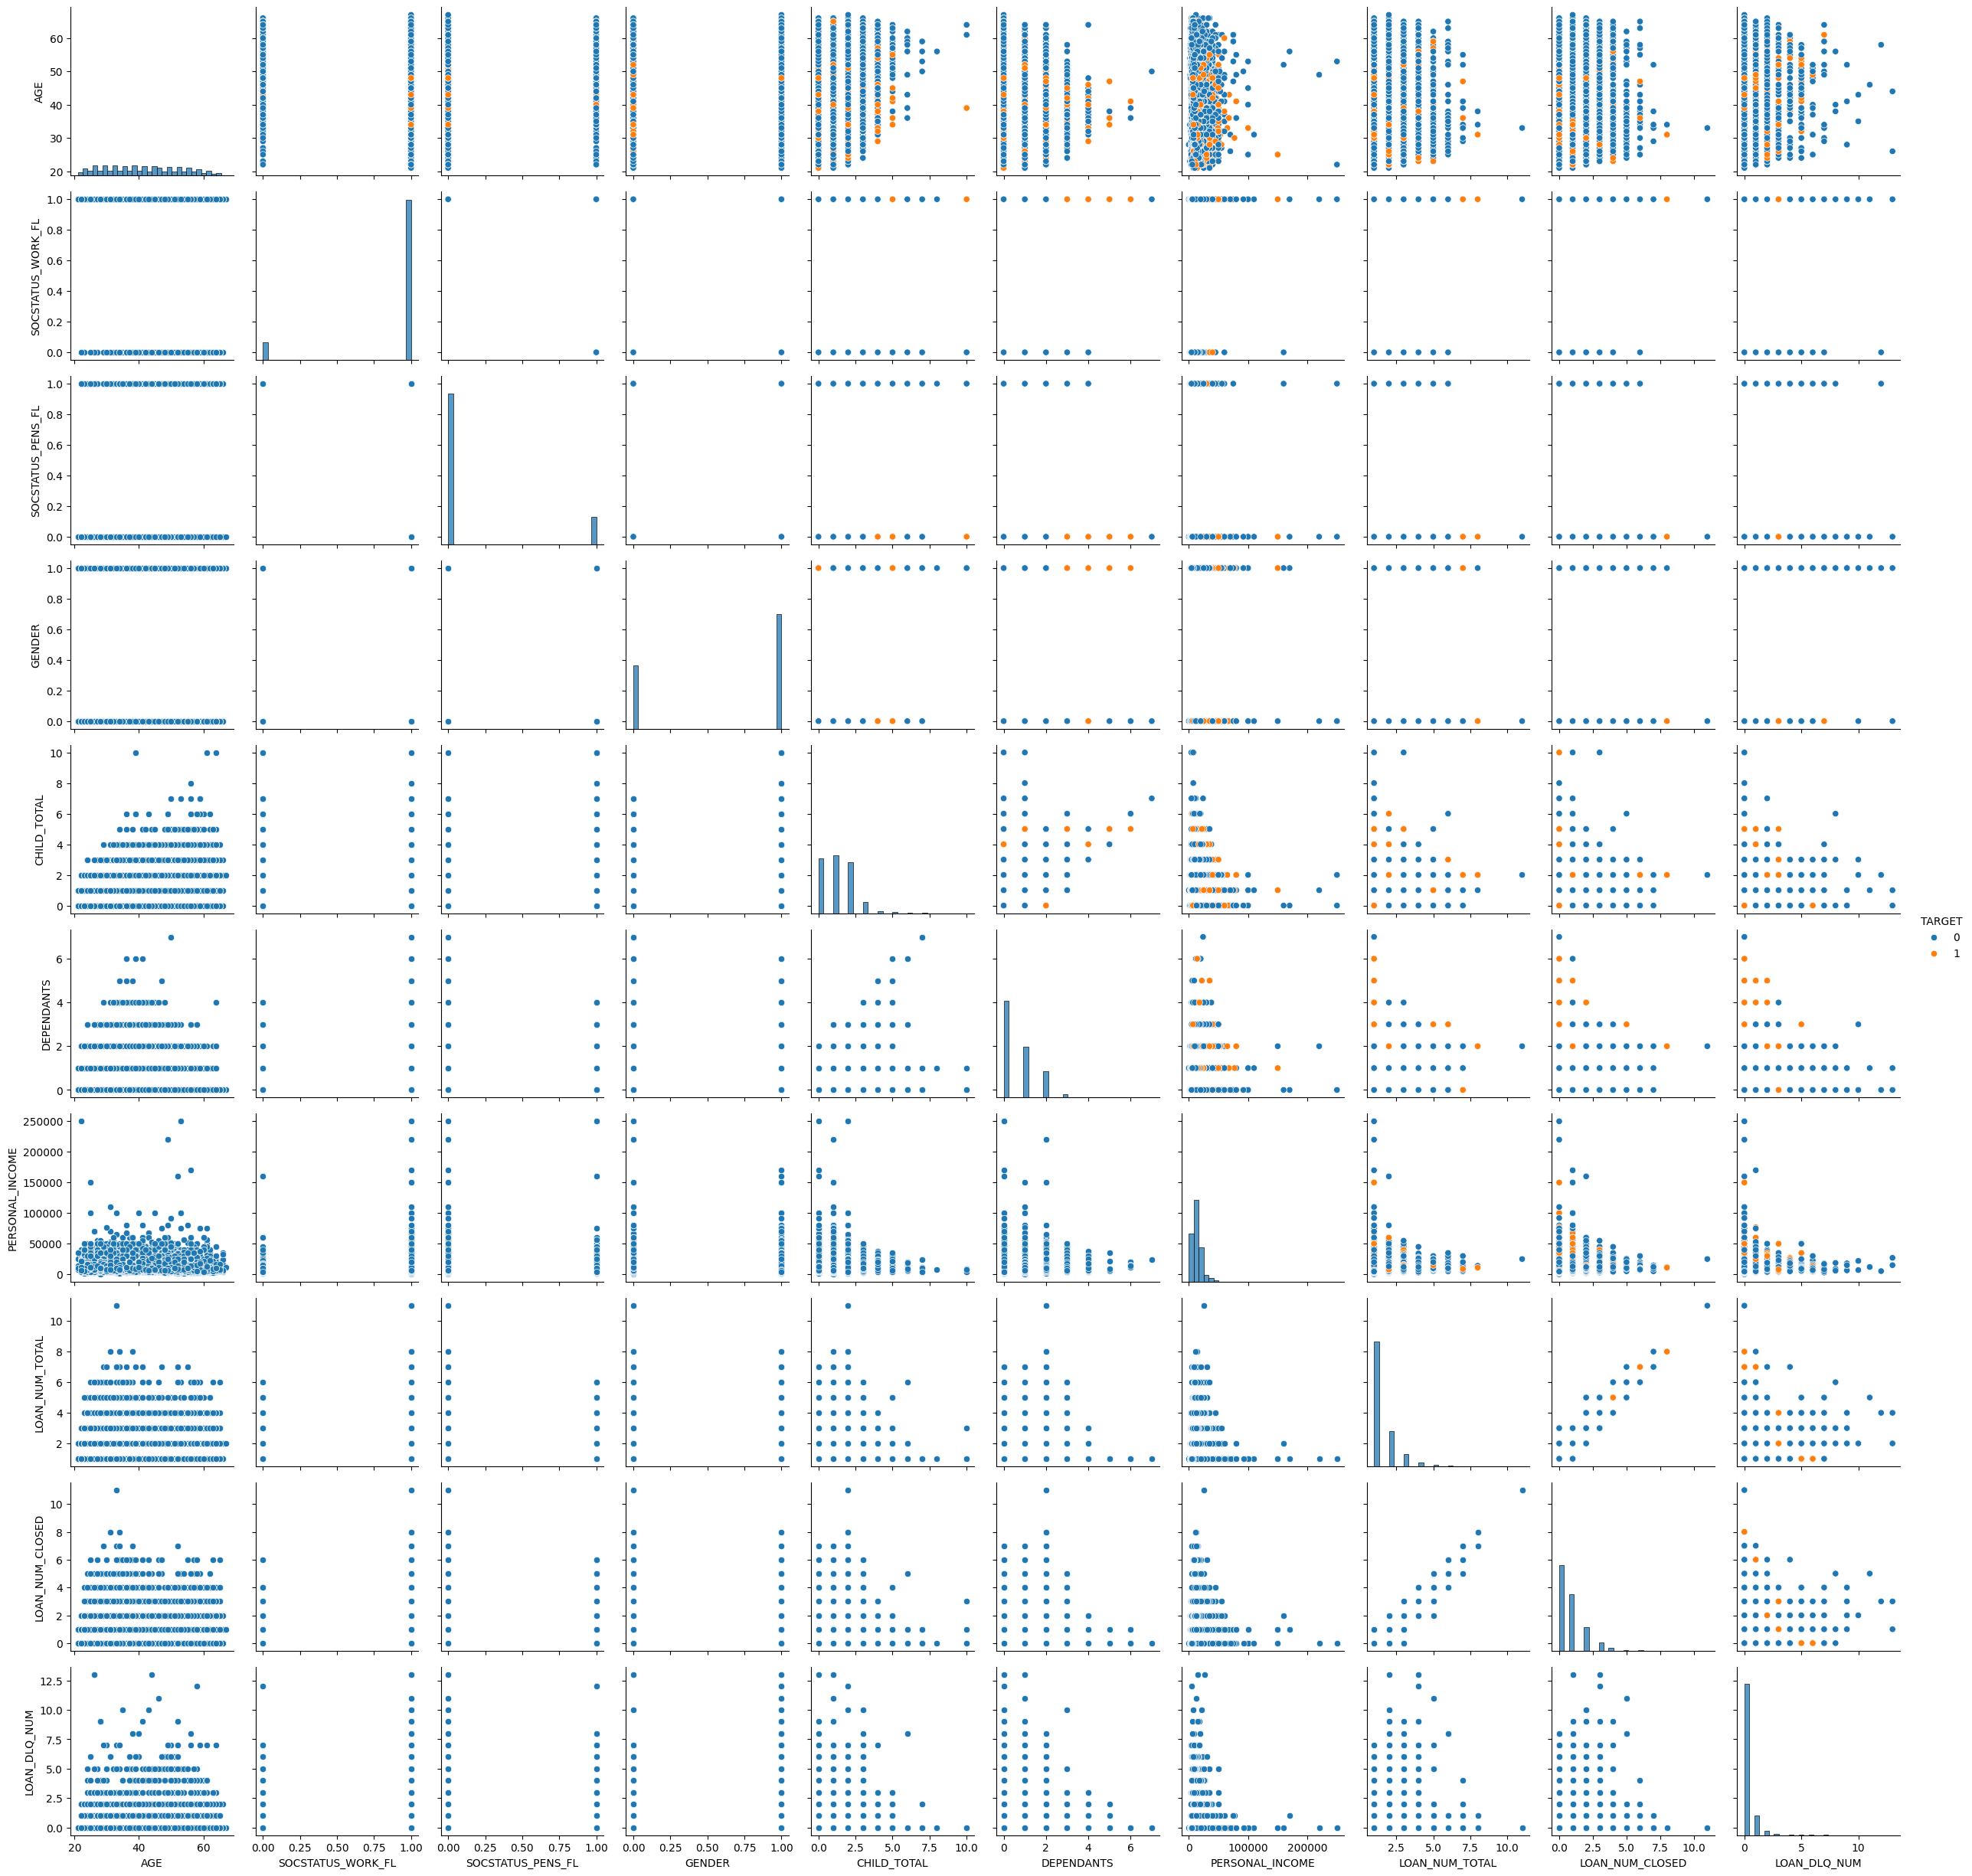

In [14]:
g1 = sns.PairGrid(df, height = 2.5, hue=target_feature_name)
g1.map_diag(sns.histplot, bins=30, hue=None)
g1.map_lower(sns.scatterplot, hue=None)
g1.map_upper(sns.scatterplot)
g1.add_legend();

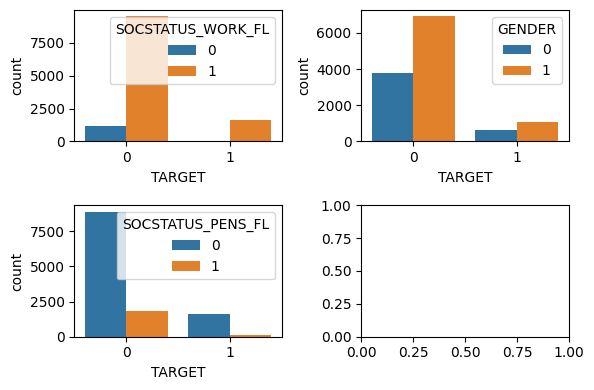

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(6,4))
# fig.suptitle('Распределение целевой переменной')
# plt.figure(figsize=(4,3))
sns.countplot(ax=axs[0, 0], data=df, x=target_feature_name, hue='SOCSTATUS_WORK_FL')
sns.countplot(ax=axs[1, 0], data=df, x=target_feature_name, hue='SOCSTATUS_PENS_FL')
sns.countplot(ax=axs[0, 1], data=df, x=target_feature_name, hue='GENDER')

# sns.countplot(ax=axs[0, 0], data=df, x='SOCSTATUS_WORK_FL', hue='TARGET')
# sns.countplot(ax=axs[1, 0], data=df, x='SOCSTATUS_PENS_FL', hue='TARGET')
# sns.countplot(ax=axs[0, 1], data=df, x='GENDER', hue='TARGET')
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()

# Работающих больше, чем неработающих
# Неработающие люди характерны только для значения целевого признака, обозначающего отсутствие отклика. Это может быть одним из критериев разделения.
# Мужчин в датасете больше чем женщин
# Какой то явной зависимости целевой переменной от признака GENDER не наблюдается.
# Пенсионеров в датасете меньше, чем работающих
# Какой то явной зависимости целевой переменной от признака SOCSTATUS_PENS_FL не наблюдается.



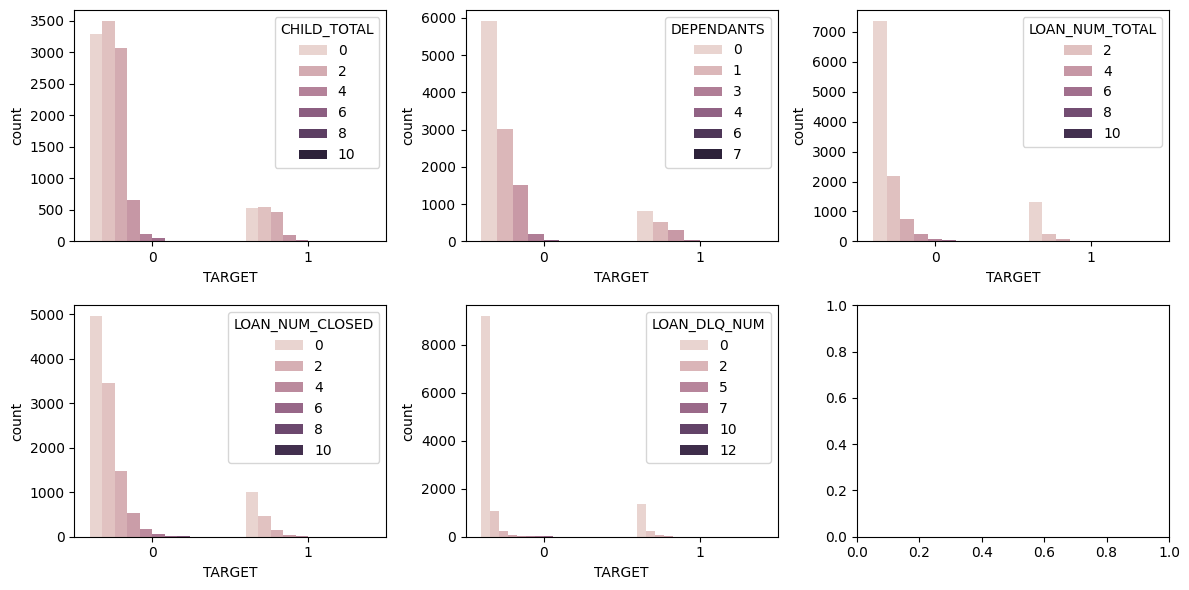

In [102]:
fig, axs = plt.subplots(2, 3, figsize=(12,6))
# fig.suptitle('Распределение целевой переменной')
# plt.figure(figsize=(4,3))
sns.countplot(ax=axs[0, 0], data=df, x=target_feature_name, hue='CHILD_TOTAL')#, stat='probability' )
sns.countplot(ax=axs[0, 1], data=df, x=target_feature_name, hue='DEPENDANTS')
sns.countplot(ax=axs[0, 2], data=df, x=target_feature_name, hue='LOAN_NUM_TOTAL')
sns.countplot(ax=axs[1, 0], data=df, x=target_feature_name, hue='LOAN_NUM_CLOSED')
sns.countplot(ax=axs[1, 1], data=df, x=target_feature_name, hue='LOAN_DLQ_NUM')

# sns.countplot(ax=axs[0, 0], data=df, x='SOCSTATUS_WORK_FL', hue='TARGET')
# sns.countplot(ax=axs[1, 0], data=df, x='SOCSTATUS_PENS_FL', hue='TARGET')
# sns.countplot(ax=axs[0, 1], data=df, x='GENDER', hue='TARGET')
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()

# Видим, что форма графиков для значений целевых переменных повторяется для каждого признака.
# Какого то явного разделения не наблюдается.



In [205]:
# df['PERSONAL_INCOME'] = np.log(df['PERSONAL_INCOME'])

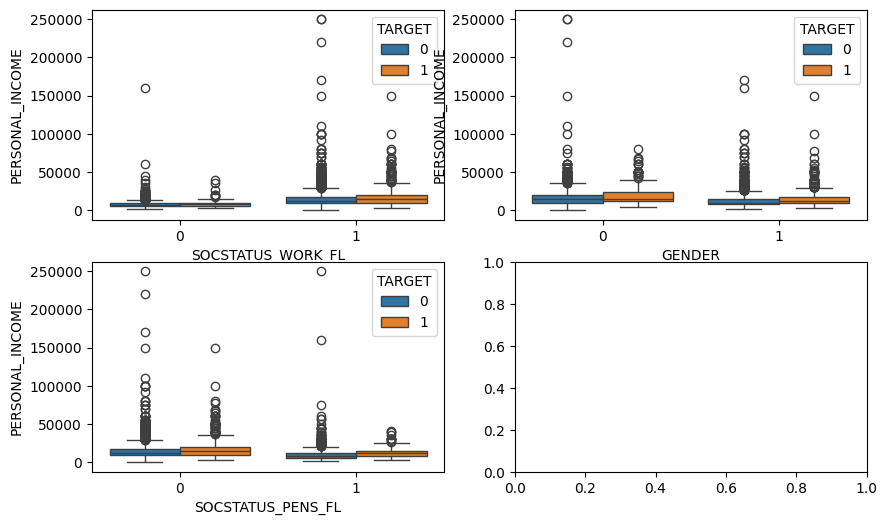

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))
# fig.suptitle('Распределение целевой переменной')
# plt.figure(figsize=(4,3))
sns.boxplot(ax=axs[0, 0], data=df, x='SOCSTATUS_WORK_FL', y='PERSONAL_INCOME', hue=target_feature_name)
sns.boxplot(ax=axs[1, 0], data=df, x='SOCSTATUS_PENS_FL', y='PERSONAL_INCOME', hue=target_feature_name)
sns.boxplot(ax=axs[0, 1], data=df, x='GENDER', y='PERSONAL_INCOME', hue=target_feature_name);
# sns.boxplot(data=df, x='TARGET', y='PERSONAL_INCOME', hue='GENDER')
# Не наблюдаем явной разделяющей способности

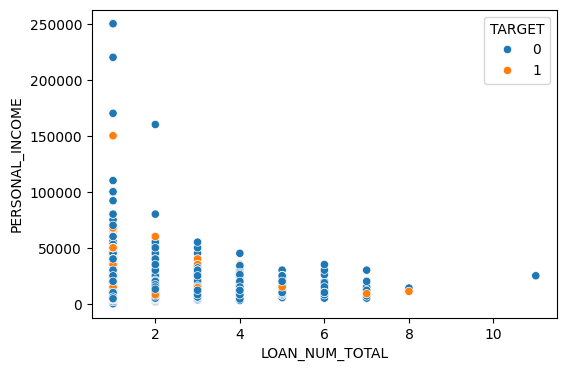

In [207]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='LOAN_NUM_TOTAL', y='PERSONAL_INCOME', hue=target_feature_name );
# Не наблюдаем разделяющей способности

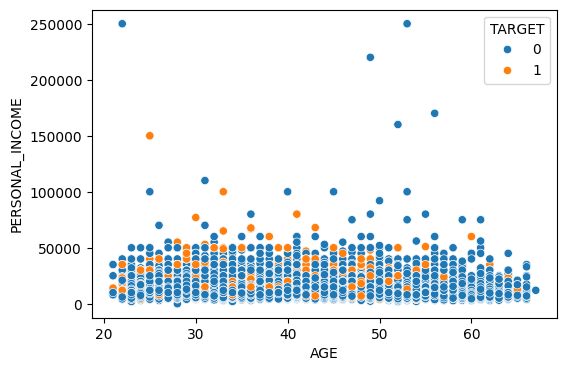

In [208]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='AGE', y='PERSONAL_INCOME', hue=target_feature_name );

In [209]:
df.pivot_table(index=['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL'], columns=[target_feature_name], values=['PERSONAL_INCOME'], aggfunc='median')
# df.pivot_table(index=['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL'], columns=['TARGET'], values=['PERSONAL_INCOME_LOG'], aggfunc='median')
# Не наблюдаем явного различия

PERSONAL_INCOME         
TARGET                                                   0        1
GENDER SOCSTATUS_WORK_FL SOCSTATUS_PENS_FL                         
0      0                 1                          7260.0   7500.0
       1                 0                         15000.0  15000.0
                         1                         17000.0  15000.0
1      0                 1                          7000.0   8000.0
       1                 0                         10000.0  12000.0
                         1                         13500.0  13000.0

Итого:\
проанализировав признаки и их связь с целевой пременной, не наблюдаем каких то признаков\
 на основании, которых можно было бы сказать, что данные явно линейно разделимы.

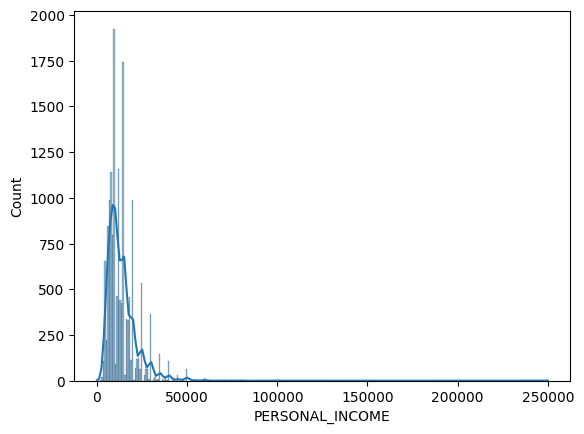

In [210]:
sns.histplot(df['PERSONAL_INCOME'], bins=300, kde=True);
# Распределение с правым хвостом. Нужно рассмотреть гипотезу о логарифмировании признака PERSONAL_INCOME. Реализовать можно т.к. доход не может быть отрицательным

In [211]:
# df['PERSONAL_INCOME_LOG'] = np.log(df['PERSONAL_INCOME'])
# df.drop(columns=['PERSONAL_INCOME_LOG'], inplace=True)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(df.copy(deep=True).drop(columns=[target_feature_name]), df.copy(deep=True)[target_feature_name]\
                                                    , train_size=0.7\
                                                    , random_state=42
                                                    , stratify=df[target_feature_name])
print(f'{[el.shape for el in [X_train, X_test, y_train, y_test]]}')

[(10656, 10), (4567, 10), (10656,), (4567,)]


In [213]:
scaler = StandardScaler().fit(X_train)
# scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [214]:
model = LogisticRegression()
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [223]:
# Метрику accuracy не применяем, т.к. классы целевой переменной не сбалансированы и мы предсказываем класс, который занимет меньшую долю.
print(precision_score(y_train, y_train_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_train, y_train_pred))
print(recall_score(y_test, y_test_pred))

0.17234927234927236
0.166005946481665
0.6537854889589906
0.6158088235294118


In [216]:
print(y_train.value_counts(), y_test.value_counts())
print(pd.DataFrame(y_train_pred).value_counts())
print(pd.DataFrame(y_test_pred).value_counts())

TARGET
0    9388
1    1268
Name: count, dtype: int64 TARGET
0    4023
1     544
Name: count, dtype: int64
0
0    5846
1    4810
Name: count, dtype: int64
0
0    2549
1    2018
Name: count, dtype: int64


In [217]:
# Попробуем применить полиномиальные признаки
from sklearn.preprocessing import PolynomialFeatures

In [225]:
pf=PolynomialFeatures()     #Linear Equation of degree 2
X_poly_train = pf.fit(X_train).transform(X_train) 
X_poly_test = pf.transform(X_test)
model_poly = LogisticRegression(class_weight='balanced')
model_poly.fit(X_poly_train, y_train)
y_poly_train_pred = model_poly.predict(X_poly_train)
y_poly_test_pred = model_poly.predict(X_poly_test)

c:\Users\Alex\Documents\GB\Python_2022\.python_b_hw\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [227]:
print(precision_score(y_train, y_poly_train_pred))
print(precision_score(y_test, y_poly_test_pred))
print(recall_score(y_train, y_poly_train_pred))
print(recall_score(y_test, y_poly_test_pred))
# Прироста метрик не наблюдается

0.1793221793221793
0.1677715451300357
0.6593059936908517
0.6047794117647058


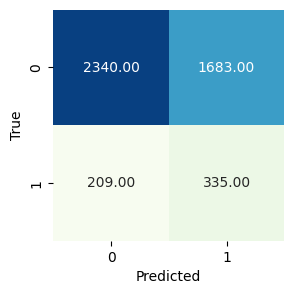

In [247]:
# Отобразим матрицу ошибок
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='.2f', cbar=False, square=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('True');

In [231]:
# Наблюдаем низкие показатели метрики ROC AUC которые показывают, что предсказания модели практически соответствуют случайному угадыванию
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(0.6148667538531638, 0.5987321522568759)

Выводы: как было сразу видно на визуализации зависимости переменных данные плохо линейно разделимы.\
Поэтому метрики качества логистической регрессии показывают низкое качество модели.\
Попытка применить полиномиальное преобразование признаков, чтобы перевести данные в пространство, где они могли бы быть разделены не помогла.